In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
     |████████████████████████████████| 181 kB 47.9 MB/s 
     |████████████████████████████████| 144 kB 36.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1283042c3cdc940f91c61fdaf4da7ae10714c44f0ed43063ded3a6bbea5061c3
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
wandb.init(project="Assignment1-FeedFwdNeuralNw", entity="cs21s048-cs21s058")

In [ ]:
sweep_config = {
    "method":"random"
}
metric = {
    "name" : "val_accuracy",
    "goal" : "maximize"
}

sweep_config['metric']=metric

parameter_dict = {
      "epochs" : {
      "values" : [5, 10]
      },
      "learning_rate" : {
      "values" : [1e-3, 1e-4]
      },
      "h_layers" : {
      "values" : [3, 4, 5]
      },
      "neurons" : {
      "values" : [32, 64, 128]
      },
      "optimizer" : {
      "values" : ['sgd', 'mgd', 'nesterov', 'rmsprop', 'adam', 'nadam']  
      },
      "batch_size" : {
      "values" : [16, 32, 64]
      },
      "activation" : {
      "values" : ['sigmoid', 'tanh', 'relu']
      }
  } 

sweep_config['parameters']=parameter_dict

import pprint

pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'activation': {'values': ['sigmoid', 'tanh', 'relu']},
                'batch_size': {'values': [16, 32, 64]},
                'epochs': {'values': [5, 10]},
                'h_layers': {'values': [3, 4, 5]},
                'learning_rate': {'values': [0.001, 0.0001]},
                'neurons': {'values': [32, 64, 128]},
                'optimizer': {'values': ['sgd',
                                         'mgd',
                                         'nesterov',
                                         'rmsprop',
                                         'adam',
                                         'nadam']}}}
Create sweep with ID: n88c61o8
Sweep URL: https://wandb.ai/cs21s048-cs21s058/uncategorized/sweeps/n88c61o8


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

###Activation Functions

In [ ]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def d_sigmoid(x):
  return (1 - sigmoid(x)) * sigmoid(x)

def tanh(x):
  return np.tanh(x)

def d_tanh(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
  return np.where(np.asarray(x) > 0, x, 0)

def d_relu(x):
    return np.where(x <= 0, 0, 1)

def softmax(x):
    e_x = np.exp(x)
    return e_x/e_x.sum()

###Loss Function:

In [ ]:
#cross-entropy
def cross_entropy_loss(y, y_hat, i):
  return -np.log(y_hat[y[i]][0])

#squared-error
def squared_error(y, y_hat, i):
  y_hat[y[i]][0] = (1-y_hat[y[i]])**2
  return np.sum(np.square(y_hat))

In [ ]:
def cost(y, y_hat, i):
  
  m = y.shape[0]
  c = (1/m) * np.sum(cross_entropy_loss(y, y_hat))
  c = np.squeeze(c) 

  return c

###Layer Class : parameters initialization for each layer

In [ ]:
class Layer:

    activationFunc = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'relu' : (relu, d_relu),
        'softmax' : (softmax, None)
    }

    def __init__(self, inputs, neurons, activation):
        np.random.seed(33)
        sd = np.sqrt(2 / float(inputs + neurons))
        self.W = np.random.normal(0, sd, size=(neurons, inputs))  #np.random.randn(neurons, inputs)
        self.b = np.zeros((neurons, 1))
        self.act, self.d_act = self.activationFunc.get(activation)
        self.dW = 0
        self.db = 0

### Forward propagation

In [ ]:
def forward_propagation(h, layers):
  m = len(layers)
  
  layers[0].a = np.dot(layers[0].W, h)
  layers[0].h = layers[0].act(layers[0].a)
  
  for j in range(1, m-1):
    layers[j].a = np.dot(layers[j].W, layers[j-1].h)
    layers[j].h = layers[j].act(layers[j].a)

  j+=1
  layers[j].a = np.dot(layers[j].W, layers[j-1].h)
  layers[j].h = softmax(layers[j].a)

  return layers[m-1].h

###Backward_propagation

In [ ]:
def backward_propagation(l, y_hat, layers, inp):
  
  #one-hot vector
  e_l = np.zeros((y_hat.shape[0], 1))
  e_l[l] = 1
  
  layers[len(layers)-1].da = -(e_l - y_hat)                 #gradient w.r.t activation of last layer (a_L)
  
  for j in range(len(layers)-1, 0, -1):
                        
    layers[j].dW += np.dot(layers[j].da, (layers[j-1].h).T)
    layers[j].db += layers[j].da

    layers[j-1].dh = np.dot((layers[j].W).T, layers[j].da)
    layers[j-1].da = np.multiply(layers[j-1].dh, layers[j-1].d_act(layers[j-1].a))

  layers[0].dW += np.dot(layers[0].da, inp.T)
  layers[0].db += layers[0].da

  return layers


###Gradient Descent

In [ ]:
def update_params(learning_rate, layers, batch_size):
  for layer in layers:
    layer.W = layer.W - learning_rate * layer.dW/batch_size
    layer.b = layer.b - learning_rate * layer.db/batch_size

    layer.dW = 0
    layer.db = 0

###SGD / Batch Gradient Descent

In [ ]:
def sgd(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)
        #cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #stocastic gradient decent
        if (i+1) % batch_size == 0:
          update_params(learning_rate, layers, batch_size)

      costs.append(cost/m)
      
      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})
      
      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###Momentum Gradient descent

In [ ]:
def mgd(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    gamma = 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #momentum gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = gamma*layer.update_W + learning_rate*layer.dW/batch_size
            layer.update_b = gamma*layer.update_b + learning_rate*layer.dW/batch_size

            layer.W = layer.W - layer.update_W
            layer.b = layer.b - layer.update_b

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0


      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###Nesterov Gradient Descent

In [ ]:
def nesterov(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    gamma = 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        #calculate W_lookaheads
        if (i+1) % batch_size == 0:
          for layer in layers:
            layer.W = layer.W - gamma * layer.update_W
            layer.b = layer.b - gamma * layer.update_b

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #nesterov gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = gamma*layer.update_W + learning_rate*layer.dW/batch_size
            layer.update_b = gamma*layer.update_b + learning_rate*layer.dW/batch_size

            layer.W = layer.W - layer.update_W
            layer.b = layer.b - layer.update_b

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0

      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers  

###RMSProp

In [ ]:
def rmsprop(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    epsilon, beta = 1e-8, 0.9
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #rmsprop gradient decent
        if (i+1) % batch_size == 0:
          for layer in layers:

            layer.update_W = beta*layer.update_W + (1-beta)*(layer.dW/batch_size)**2
            layer.update_b = beta*layer.update_b + (1-beta)*(layer.db/batch_size)**2

            layer.W = layer.W - (learning_rate / np.sqrt(layer.update_W + epsilon)) * (layer.dW/batch_size)
            layer.b = layer.b - (learning_rate / np.sqrt(layer.update_b + epsilon)) * (layer.db/batch_size)

            layer.dW = 0
            layer.db = 0

            layer.update_W = 0
            layer.update_b = 0


      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###Adam

In [ ]:
def adam(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    epsilon, beta1, beta2 = 1e-8, 0.9, 0.99
    t = 0
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)

        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #adam gradient decent
        if (i+1) % batch_size == 0:
          t+=1

          for layer in layers:

            layer.m_W = beta1 * layer.m_W + (1-beta1)*layer.dW/batch_size
            layer.m_b = beta1 * layer.m_b + (1-beta1)*layer.db/batch_size

            layer.v_W = beta2 * layer.v_W + (1-beta2)*((layer.dW/batch_size))**2
            layer.v_b = beta2 * layer.v_b + (1-beta2)*((layer.db/batch_size))**2

            layer.m_W_hat = layer.m_W/(1-math.pow(beta1, t))
            layer.m_b_hat = layer.m_b/(1-math.pow(beta1, t))

            layer.v_W_hat = layer.v_W/(1-math.pow(beta2, t))
            layer.v_b_hat = layer.v_b/(1-math.pow(beta2, t))

            layer.W = layer.W - (learning_rate/np.sqrt(layer.v_W_hat + epsilon))*layer.m_W_hat
            layer.b = layer.b - (learning_rate/np.sqrt(layer.v_b_hat + epsilon))*layer.m_b_hat

            layer.dW = 0
            layer.db = 0

            layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0


      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
      #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
        val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      #wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###NAdam

In [ ]:
def nadam(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size):

    epsilon, beta1, beta2 = 1e-8, 0.9, 0.99
    gamma = 0.9
    t = 0
    
    m = x_train.shape[0]
    costs = []

    for epoch in range(epochs):

      for layer in layers:
        layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0
        layer.update_W = 0
        layer.update_b = 0

      cost = 0

      for i in range(m):

        inp = x_train[i].reshape(784, 1)
        
        # Feedforward
        h = inp
        h = forward_propagation(h, layers)

        # Calulate cost to plot graph
        cost += cross_entropy_loss(y_train, h, i)
        cost += squared_error(y_train, h, i)
        #cost += squared_error(y_train, h, i)

        #calculate W_lookaheads
        if (i+1) % batch_size == 0:
          for layer in layers:
            layer.W = layer.W - gamma * layer.m_W
            layer.b = layer.b - gamma * layer.m_b
        
        # Backpropagation
        backward_propagation(y_train[i], h, layers, x_train[i].reshape(784, 1))

        #adam gradient decent
        if (i+1) % batch_size == 0:
          t+=1

          for layer in layers:

            layer.m_W = beta1 * layer.m_W + (1-beta1)*layer.dW/batch_size
            layer.m_b = beta1 * layer.m_b + (1-beta1)*layer.db/batch_size

            layer.v_W = beta2 * layer.v_W + (1-beta2)*((layer.dW/batch_size))**2
            layer.v_b = beta2 * layer.v_b + (1-beta2)*((layer.db/batch_size))**2

            layer.m_W_hat = layer.m_W/(1-math.pow(beta1, t))
            layer.m_b_hat = layer.m_b/(1-math.pow(beta1, t))

            layer.v_W_hat = layer.v_W/(1-math.pow(beta2, t))
            layer.v_b_hat = layer.v_b/(1-math.pow(beta2, t))

            layer.m_dash_W = beta1 * layer.m_W_hat + (1-beta1)*layer.dW/batch_size
            layer.m_dash_b = beta1 * layer.m_b_hat + (1-beta1)*layer.db/batch_size

            layer.W = layer.W - (learning_rate/np.sqrt(layer.v_W_hat + epsilon))*layer.m_dash_W
            layer.b = layer.b - (learning_rate/np.sqrt(layer.v_b_hat + epsilon))*layer.m_dash_b

            layer.dW = 0
            layer.db = 0

            layer.m_W, layer.m_b, layer.v_W, layer.v_b, layer.m_W_hat, layer.m_b_hat, layer.v_W_hat, layer.v_b_hat = 0, 0, 0, 0, 0, 0, 0, 0


      costs.append(cost/m)

      #predict on validation data
      prediction = forward_propagation(x_val.T, layers)

      val_loss = 0
      for i in range(len(y_val)):
        #val_loss += cross_entropy_loss(y_val, prediction[:, i].reshape(10,1), i) 
        val_loss += squared_error(y_val, prediction[:, i].reshape(10,1), i) 

      val_loss = val_loss/len(y_val)
      prediction = prediction.argmax(axis=0)
      val_accuracy =  np.sum(prediction == y_val)/y_val.shape[0]

      #wandb logs
      #wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": val_accuracy, "val_loss": val_loss})
      wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_loss": val_loss})

      print("-----------------epoch "+str(epoch)+"-----------------")
      print("Cost: ", cost/m)
      print("Validation accuracy: ", val_accuracy)
      print("Validation loss: ", val_loss)

    return costs, layers

###Putting all togather:

###Optimizer

In [ ]:
def optimizor(layers, optimizer, epochs, learning_rate, x_train, y_train, x_val, y_val, batch_size):
  
  if optimizer == "sgd":
    return sgd(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "mgd":
    return mgd(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "nesterov":
    return nesterov(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "rmsprop":
    return rmsprop(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "adam":
    return adam(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  elif optimizer == "nadam":
    return nadam(epochs, layers, learning_rate, x_train, y_train, x_val, y_val, batch_size)
  else:
    print("No optimization algorithm named "+optimizer+" found")
    return "Error", "Error"

###Function to Predict

In [ ]:
def predict(input, y, layers):
 
  prediction = forward_propagation(input, layers)

  loss = 0
  for i in range(len(y)):
    #loss += squared_error(y, prediction[:, i].reshape(10,1), i)
    loss += cross_entropy_loss(y, prediction[:, i].reshape(10,1), i) 

  prediction = prediction.argmax(axis=0)
  accuracy =  np.sum(prediction == y)/y.shape[0]

  return prediction, accuracy, loss/len(y)

###Import dataset and putting in appropriate format

In [ ]:
from keras.datasets import fashion_mnist
(x_train_org, y_train_org), (x_test_org, y_test_org) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
print("x_train shape: ", x_train_org.shape)
print("y_train shape: ", y_train_org.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)


###Display images corresponding to each class

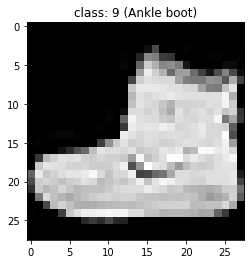

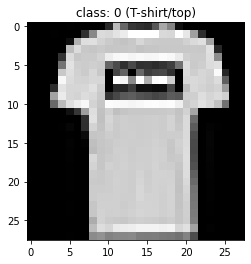

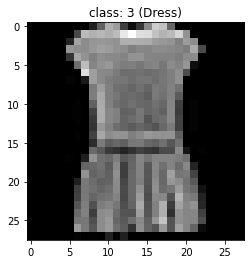

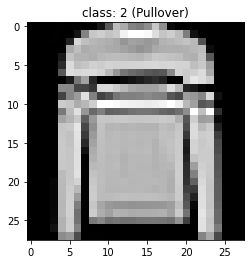

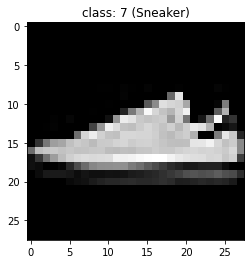

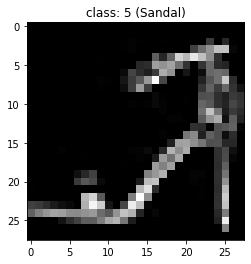

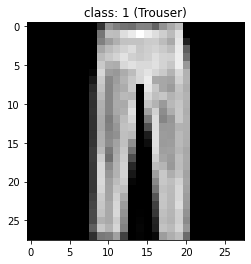

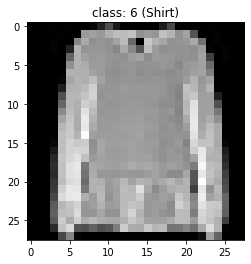

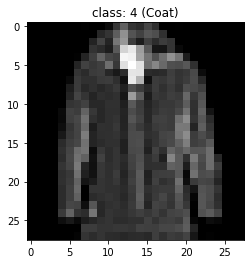

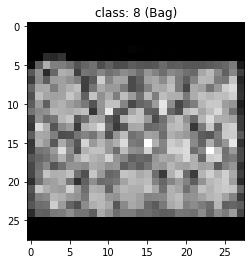

In [ ]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
img_list = []
idx_list = []
count = 0
for i in range(y_train_org.shape[0]):
    if y_train_org[i] in idx_list:
      continue
    else:
      idx_list.append(y_train_org[i])
      img_list.append(x_train_org[i])
    if len(idx_list) == 10:
      break

wandb_list = []
for j in range(10):
  plt.imshow(img_list[j], cmap='gray')
  plt.title("class: "+ str(idx_list[j]) + " ("+labels[idx_list[j]]+")")
  wandb.log({"img": [wandb.Image(plt.imshow(img_list[j], cmap='gray'), caption="class: "+ str(idx_list[j]) + " ("+labels[idx_list[j]]+")")]})
  plt.show()

####Flattening the data

In [ ]:
x_train_temp = x_train_org.reshape(x_train_org.shape[0], -1)
y_train_temp = y_train_org
x_test = x_test_org.reshape(x_test_org.shape[0], -1)
y_test = y_test_org

####Splliting dataset into training and validation

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.1, random_state=33)

In [ ]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_val shape: ", x_val.shape)
print("y_val shape: ", y_val.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (54000, 784)
y_train shape:  (54000,)
x_val shape:  (6000, 784)
y_val shape:  (6000,)
x_test shape:  (10000, 784)
y_test shape:  (10000,)


###Train model

In [ ]:
def model_train(epochs, learning_rate, neurons, h_layers, activation, batch_size, optimizer, x_train, y_train, x_val, y_val):

  layers= [Layer(x_train.shape[1], neurons, activation)]
  for _ in range(0, h_layers-1):
    layers.append(Layer(neurons, neurons, activation))
  layers.append(Layer(neurons, 10, 'softmax'))

  costs, layers = optimizor(layers, optimizer, epochs, learning_rate, x_train, y_train, x_val, y_val, batch_size)

  output_test, accuracy_test, loss_test = predict(x_test.T, y_test, layers)

  print("Test accuracy: ", accuracy_test)
  print("Test loss: ", loss_test)

  return output_test

###Train Model with wandb

In [ ]:
def model_train_wandb(config=None):

  with wandb.init(config=config):
    config=wandb.config

    layers= [Layer(x_train.shape[1], config.neurons, config.activation)]
    for _ in range(0, config.h_layers-1):
      layers.append(Layer(config.neurons, config.neurons, config.activation))
    layers.append(Layer(config.neurons, 10, 'softmax'))

    costs, layers = optimizor(layers, config.optimizer, config.epochs, config.learning_rate, x_train, y_train, x_val, y_val, config.batch_size)

    #output_val, accuracy_val, loss_val = predict(x_val.T, y_val, layers)
    output_test, accuracy_test, loss_test = predict(x_test.T, y_test, layers)

    #wandb.log({"epoch": epoch, "loss": costs[len(costs)-1], "val_accuracy": accuracy_val, "accuracy": accuracy_test, "val_loss": loss_val})
    wandb.log({"accuracy": accuracy_test})

    #print("Validation accuracy: ", accuracy_val)
    #print("Validation loss: ", loss_val)
    print("Test accuracy: ", accuracy_test)
    print("Test loss: ", loss_test)

In [ ]:
wandb.agent(sweep_id, model_train_wandb, count=20)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: bar35nud with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.061522853340818
Validation accuracy:  0.7135
Validation loss:  9.670083499247854
-----------------epoch 1-----------------
Cost:  0.7291595730550499
Validation accuracy:  0.7445
Validation loss:  9.754313486127312
-----------------epoch 2-----------------
Cost:  0.6854878221728514
Validation accuracy:  0.7555
Validation loss:  9.790533344694923
-----------------epoch 3-----------------
Cost:  0.6630630898581763
Validation accuracy:  0.7431666666666666
Validation loss:  9.863372785782081
-----------------epoch 4-----------------
Cost:  0.6759628791649946
Validation accuracy:  0.7286666666666667
Validation loss:  9.990089176434973
-----------------epoch 5-----------------
Cost:  0.6762930562909901
Validation accuracy:  0.7435
Validation loss:  10.001482364113087
-----------------epoch 6-----------------
Cost:  0.6593609432507653
Validation accuracy:  0.7505
Validation loss:  10.078049907335418
-----------------epoch 7-----------------
Co

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▆█▆▄▆▇▇▃▅
val_loss,▁▂▂▃▅▅▅▇▄█
accuracy,0.7303
epoch,9
loss,0.64904
val_accuracy,0.73567
val_loss,10.3074


wandb: Agent Starting Run: 5amll68k with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: cs21s048-cs21s058 (use `wandb login --relogin` to force relogin)


-----------------epoch 0-----------------
Cost:  1.7468173909828697
Validation accuracy:  0.7415
Validation loss:  70.76193631786441
-----------------epoch 1-----------------
Cost:  1.0716118442126148
Validation accuracy:  0.7643333333333333
Validation loss:  72.68658845139105
-----------------epoch 2-----------------
Cost:  1.0700197881598374
Validation accuracy:  0.7783333333333333
Validation loss:  119.09490299940855
-----------------epoch 3-----------------
Cost:  1.0855233773595545
Validation accuracy:  0.8093333333333333
Validation loss:  140.7614291651645
-----------------epoch 4-----------------
Cost:  1.0755011430906565
Validation accuracy:  0.8031666666666667
Validation loss:  116.55402913859525
Test accuracy:  0.8001
Test loss:  116.48735833524381


accuracy,▁
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,▁▃▅█▇
val_loss,▁▁▆█▆
accuracy,0.8001
epoch,4
loss,1.0755
val_accuracy,0.80317
val_loss,116.55403


wandb: Agent Starting Run: viherq64 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 32
wandb: 	optimizer: mgd


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


-----------------epoch 0-----------------
Cost:  2.567232384889911
Validation accuracy:  0.10133333333333333
Validation loss:  11.250704939480684
-----------------epoch 1-----------------
Cost:  2.532482649853972
Validation accuracy:  0.10133333333333333
Validation loss:  11.21906228137059
-----------------epoch 2-----------------
Cost:  2.503288243507093
Validation accuracy:  0.10133333333333333
Validation loss:  11.192143295535288
-----------------epoch 3-----------------
Cost:  2.4782874761822336
Validation accuracy:  0.10133333333333333
Validation loss:  11.168872189377696
-----------------epoch 4-----------------
Cost:  2.4567021107693536
Validation accuracy:  0.10133333333333333
Validation loss:  11.14861904113801
Test accuracy:  0.1
Test loss:  11.65742017624207


accuracy,▁
epoch,▁▃▅▆█
loss,█▆▄▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▂▁
accuracy,0.1
epoch,4
loss,2.4567
val_accuracy,0.10133
val_loss,11.14862


wandb: Agent Starting Run: 1e0k0a0z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 32
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  2.193424713002227
Validation accuracy:  0.228
Validation loss:  10.513903026905771
-----------------epoch 1-----------------
Cost:  1.6180805520926644
Validation accuracy:  0.283
Validation loss:  10.294041886591335
-----------------epoch 2-----------------
Cost:  1.3819820754192667
Validation accuracy:  0.4251666666666667
Validation loss:  10.373081402254062
-----------------epoch 3-----------------
Cost:  1.2281781139076384
Validation accuracy:  0.5205
Validation loss:  10.568495011186775
-----------------epoch 4-----------------
Cost:  1.0963761450776779
Validation accuracy:  0.545
Validation loss:  11.19522257098601
-----------------epoch 5-----------------
Cost:  0.9998765817656506
Validation accuracy:  0.5406666666666666
Validation loss:  11.880143331865359
-----------------epoch 6-----------------
Cost:  0.9531852772174217
Validation accuracy:  0.5991666666666666
Validation loss:  12.523781299939634
-----------------epoch 7-------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▂▄▅▆▆▇▇▇█
val_loss,▁▁▁▂▃▄▆▆▇█
accuracy,0.6908
epoch,9
loss,0.89978
val_accuracy,0.693
val_loss,13.71113


wandb: Agent Starting Run: 341lwtx6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  0.9052490817355433
Validation accuracy:  0.724
Validation loss:  12.887181891069163
-----------------epoch 1-----------------
Cost:  0.7492279574218258
Validation accuracy:  0.7326666666666667
Validation loss:  17.346602883388158
-----------------epoch 2-----------------
Cost:  0.7078334134244053
Validation accuracy:  0.7533333333333333
Validation loss:  17.8532057641791
-----------------epoch 3-----------------
Cost:  0.6945716730403783
Validation accuracy:  0.759
Validation loss:  21.43866877640397
-----------------epoch 4-----------------
Cost:  0.6983661115701432
Validation accuracy:  0.7653333333333333
Validation loss:  23.902632184269518
Test accuracy:  0.7606
Test loss:  24.43646239959209


accuracy,▁
epoch,▁▃▅▆█
loss,█▃▁▁▁
val_accuracy,▁▂▆▇█
val_loss,▁▄▄▆█
accuracy,0.7606
epoch,4
loss,0.69837
val_accuracy,0.76533
val_loss,23.90263


wandb: Agent Starting Run: cu0wlctj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  3.8787830819386917
Validation accuracy:  0.6186666666666667
Validation loss:  116.27902888071003
-----------------epoch 1-----------------
Cost:  4.632369392817406
Validation accuracy:  0.474
Validation loss:  51.633214695622584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


-----------------epoch 2-----------------
Cost:  inf
Validation accuracy:  0.31466666666666665
Validation loss:  78.71099443407665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


-----------------epoch 3-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 4-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 5-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 6-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 7-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 8-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 9-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
Test accuracy:  0.1
Test loss:  nan


accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁█
val_accuracy,█▆▄▁▁▁▁▁▁▁
val_loss,█▁▄
accuracy,0.1
epoch,9
loss,nan
val_accuracy,0.103
val_loss,nan


wandb: Agent Starting Run: drj2phdn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  1.061522853340818
Validation accuracy:  0.7135
Validation loss:  9.670083499247854
-----------------epoch 1-----------------
Cost:  0.7291595730550499
Validation accuracy:  0.7445
Validation loss:  9.754313486127312
-----------------epoch 2-----------------
Cost:  0.6854878221728514
Validation accuracy:  0.7555
Validation loss:  9.790533344694923
-----------------epoch 3-----------------
Cost:  0.6630630898581763
Validation accuracy:  0.7431666666666666
Validation loss:  9.863372785782081
-----------------epoch 4-----------------
Cost:  0.6759628791649946
Validation accuracy:  0.7286666666666667
Validation loss:  9.990089176434973
Test accuracy:  0.7194
Test loss:  10.524638974113474


accuracy,▁
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_accuracy,▁▆█▆▄
val_loss,▁▃▄▅█
accuracy,0.7194
epoch,4
loss,0.67596
val_accuracy,0.72867
val_loss,9.99009


wandb: Agent Starting Run: 7gm9u8kz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 32
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  4.910523620109879
Validation accuracy:  0.6525
Validation loss:  76.08015001822528
-----------------epoch 1-----------------
Cost:  0.9751802613808681
Validation accuracy:  0.6771666666666667
Validation loss:  94.3256607912939
-----------------epoch 2-----------------
Cost:  0.9022022423561483
Validation accuracy:  0.7215
Validation loss:  89.10252797115943
-----------------epoch 3-----------------
Cost:  0.8601455431383496
Validation accuracy:  0.7461666666666666
Validation loss:  82.78785562689647
-----------------epoch 4-----------------
Cost:  0.82159106021109
Validation accuracy:  0.7618333333333334
Validation loss:  70.1448817684004
Test accuracy:  0.7594
Test loss:  63.753881725699465


accuracy,▁
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,▁▃▅▇█
val_loss,▃█▆▅▁
accuracy,0.7594
epoch,4
loss,0.82159
val_accuracy,0.76183
val_loss,70.14488


wandb: Agent Starting Run: srw7akso with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: rmsprop


-----------------epoch 0-----------------
Cost:  3.398324292917004
Validation accuracy:  0.783
Validation loss:  87.75906681039454
-----------------epoch 1-----------------
Cost:  1.8503079571274004
Validation accuracy:  0.8046666666666666
Validation loss:  230.0139931259216
-----------------epoch 2-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 3-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 4-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 5-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 6-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 7-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 8-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
---

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁
val_accuracy,██▁▁▁▁▁▁▁▁
val_loss,▁█
accuracy,0.1
epoch,9
loss,nan
val_accuracy,0.103
val_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: socw6n6k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  1.205854409001465
Validation accuracy:  0.6771666666666667
Validation loss:  10.408785272098672
-----------------epoch 1-----------------
Cost:  0.7651112356306005
Validation accuracy:  0.726
Validation loss:  11.465121553152297
-----------------epoch 2-----------------
Cost:  0.7374041763988418
Validation accuracy:  0.7608333333333334
Validation loss:  12.415985655430864
-----------------epoch 3-----------------
Cost:  0.7118422820497169
Validation accuracy:  0.773
Validation loss:  12.719351907354952
-----------------epoch 4-----------------
Cost:  0.7034944950469278
Validation accuracy:  0.7728333333333334
Validation loss:  14.645660994921585
Test accuracy:  0.7738
Test loss:  15.168244797542878


accuracy,▁
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_accuracy,▁▅▇██
val_loss,▁▃▄▅█
accuracy,0.7738
epoch,4
loss,0.70349
val_accuracy,0.77283
val_loss,14.64566


wandb: Agent Starting Run: zl522j5x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  0.9844740368713516
Validation accuracy:  0.7475
Validation loss:  10.048256493759963
-----------------epoch 1-----------------
Cost:  0.6557004871179384
Validation accuracy:  0.7701666666666667
Validation loss:  10.507875105505594
-----------------epoch 2-----------------
Cost:  0.6128330443813872
Validation accuracy:  0.7761666666666667
Validation loss:  10.857073971814652
-----------------epoch 3-----------------
Cost:  0.6012644742369269
Validation accuracy:  0.7851666666666667
Validation loss:  11.480240236134252
-----------------epoch 4-----------------
Cost:  0.5791638380893201
Validation accuracy:  0.793
Validation loss:  12.218713246523972
-----------------epoch 5-----------------
Cost:  0.5660437297779143
Validation accuracy:  0.7931666666666667
Validation loss:  12.689107343965807
-----------------epoch 6-----------------
Cost:  0.5533542446615367
Validation accuracy:  0.7996666666666666
Validation loss:  13.5682128001235
-----

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,▁▂▂▃▄▄▆▇▇█
accuracy,0.8033
epoch,9
loss,0.53688
val_accuracy,0.80483
val_loss,15.50639


wandb: Agent Starting Run: kbezi4ck with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	neurons: 128
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  0.9195954657549971
Validation accuracy:  0.7588333333333334
Validation loss:  10.60353793443531
-----------------epoch 1-----------------
Cost:  0.6431836962370053
Validation accuracy:  0.7653333333333333
Validation loss:  10.67697992401406
-----------------epoch 2-----------------
Cost:  0.5972003478951535
Validation accuracy:  0.7866666666666666
Validation loss:  10.605381059935745
-----------------epoch 3-----------------
Cost:  0.56932101877416
Validation accuracy:  0.7928333333333333
Validation loss:  10.42134001036276
-----------------epoch 4-----------------
Cost:  0.5482241801986741
Validation accuracy:  0.7978333333333333
Validation loss:  10.504252967330801
-----------------epoch 5-----------------
Cost:  0.5352096298162209
Validation accuracy:  0.8088333333333333
Validation loss:  10.330516574589547
-----------------epoch 6-----------------
Cost:  0.5285994781379333
Validation accuracy:  0.8075
Validation loss:  10.73532896551

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▂▄▅▆▇▇███
val_loss,▃▃▃▂▂▁▄▃▇█
accuracy,0.813
epoch,9
loss,0.51433
val_accuracy,0.81333
val_loss,11.40277


wandb: Agent Starting Run: 2g18xl5c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  1.6364923474762294
Validation accuracy:  0.6788333333333333
Validation loss:  28.798393691298926
-----------------epoch 1-----------------
Cost:  0.8186207769089474
Validation accuracy:  0.7323333333333333
Validation loss:  29.146345721970235
-----------------epoch 2-----------------
Cost:  0.7155110211770658
Validation accuracy:  0.7435
Validation loss:  29.395112184170166
-----------------epoch 3-----------------
Cost:  0.6584155060617946
Validation accuracy:  0.7538333333333334
Validation loss:  30.18055525739696
-----------------epoch 4-----------------
Cost:  0.6212564108333857
Validation accuracy:  0.7606666666666667
Validation loss:  30.58883151295902
-----------------epoch 5-----------------
Cost:  0.5945575910426776
Validation accuracy:  0.7685
Validation loss:  31.049671833810134
-----------------epoch 6-----------------
Cost:  0.5736776845126095
Validation accuracy:  0.7765
Validation loss:  31.39947910589295
-----------------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,▁▂▂▄▅▆▇▇██
accuracy,0.7824
epoch,9
loss,0.53024
val_accuracy,0.79133
val_loss,32.01418


wandb: Agent Starting Run: vnx2yisx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	h_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  2.506900628284197
Validation accuracy:  0.10183333333333333
Validation loss:  11.144946297494018
-----------------epoch 1-----------------
Cost:  2.403748683484547
Validation accuracy:  0.10183333333333333
Validation loss:  11.076199145472371
-----------------epoch 2-----------------
Cost:  2.3536074456786795
Validation accuracy:  0.10183333333333333
Validation loss:  11.039333379823166
-----------------epoch 3-----------------
Cost:  2.3258870092957933
Validation accuracy:  0.10183333333333333
Validation loss:  11.018061023082598
-----------------epoch 4-----------------
Cost:  2.309656431340505
Validation accuracy:  0.10816666666666666
Validation loss:  11.00499244738326
-----------------epoch 5-----------------
Cost:  2.2995005367495702
Validation accuracy:  0.13566666666666666
Validation loss:  10.99649149585293
-----------------epoch 6-----------------
Cost:  2.2927511118501105
Validation accuracy:  0.15283333333333332
Validation lo

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▁▁▁▂▄▆▆▆█
val_loss,█▅▄▃▂▂▁▁▁▁
accuracy,0.1772
epoch,9
loss,2.28097
val_accuracy,0.17983
val_loss,10.97955


wandb: Agent Starting Run: 8u5n72gr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  1.546808128841947
Validation accuracy:  0.651
Validation loss:  75.03613720715475
-----------------epoch 1-----------------
Cost:  0.9608693100877843
Validation accuracy:  0.7198333333333333
Validation loss:  39.68939425502282
-----------------epoch 2-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 3-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 4-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 5-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 6-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 7-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 8-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
---

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁
val_accuracy,▇█▁▁▁▁▁▁▁▁
val_loss,█▁
accuracy,0.1
epoch,9
loss,nan
val_accuracy,0.103
val_loss,nan


wandb: Agent Starting Run: mw4jtqy1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 128
wandb: 	optimizer: mgd


-----------------epoch 0-----------------
Cost:  1.7160610469161262
Validation accuracy:  0.7406666666666667
Validation loss:  46.60595166361669
-----------------epoch 1-----------------
Cost:  0.7512926659249081
Validation accuracy:  0.7776666666666666
Validation loss:  50.327278597970725
-----------------epoch 2-----------------
Cost:  0.6260192752011228
Validation accuracy:  0.7891666666666667
Validation loss:  52.77934606229204
-----------------epoch 3-----------------
Cost:  0.5622929229495173
Validation accuracy:  0.7971666666666667
Validation loss:  52.920759145246365
-----------------epoch 4-----------------
Cost:  0.520460948595072
Validation accuracy:  0.8015
Validation loss:  53.2718945626917
-----------------epoch 5-----------------
Cost:  0.4905929981188501
Validation accuracy:  0.8028333333333333
Validation loss:  55.195617676834715
-----------------epoch 6-----------------
Cost:  0.46692843767814
Validation accuracy:  0.8083333333333333
Validation loss:  55.6333910881727

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,▁▄▅▆▆▇▇███
accuracy,0.8145
epoch,9
loss,0.41872
val_accuracy,0.81483
val_loss,56.23197


wandb: Agent Starting Run: q5n2nv2s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 32
wandb: 	optimizer: sgd


-----------------epoch 0-----------------
Cost:  1.908258216568108
Validation accuracy:  0.4746666666666667
Validation loss:  10.381352689810889
-----------------epoch 1-----------------
Cost:  1.5335412942278206
Validation accuracy:  0.5905
Validation loss:  10.122922931940584
-----------------epoch 2-----------------
Cost:  1.3059804209473447
Validation accuracy:  0.6243333333333333
Validation loss:  9.948638438540312
-----------------epoch 3-----------------
Cost:  1.1410357362954318
Validation accuracy:  0.6451666666666667
Validation loss:  9.82496261973441
-----------------epoch 4-----------------
Cost:  1.0287121116366098
Validation accuracy:  0.679
Validation loss:  9.749150435318922
-----------------epoch 5-----------------
Cost:  0.9461234889921201
Validation accuracy:  0.6963333333333334
Validation loss:  9.699756586748327
-----------------epoch 6-----------------
Cost:  0.8915704823781715
Validation accuracy:  0.714
Validation loss:  9.662800566723124
-----------------epoch 

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
accuracy,0.7289
epoch,9
loss,0.77682
val_accuracy,0.73133
val_loss,9.59292


wandb: Agent Starting Run: yon2274k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 64
wandb: 	optimizer: nesterov


-----------------epoch 0-----------------
Cost:  1.9847738311749983
Validation accuracy:  0.5415
Validation loss:  10.409032191048453
-----------------epoch 1-----------------
Cost:  1.5093528629490687
Validation accuracy:  0.6171666666666666
Validation loss:  10.099379717472457
-----------------epoch 2-----------------
Cost:  1.2681169657241986
Validation accuracy:  0.6576666666666666
Validation loss:  9.923043095785802
-----------------epoch 3-----------------
Cost:  1.1194054418533157
Validation accuracy:  0.681
Validation loss:  9.815213020356595
-----------------epoch 4-----------------
Cost:  1.019869573647261
Validation accuracy:  0.694
Validation loss:  9.756080913528157
-----------------epoch 5-----------------
Cost:  0.9453367797725225
Validation accuracy:  0.7085
Validation loss:  9.705104950509355
-----------------epoch 6-----------------
Cost:  0.8912819297251098
Validation accuracy:  0.7225
Validation loss:  9.674365453453024
-----------------epoch 7-----------------
Cost

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.7459
epoch,9
loss,0.77563
val_accuracy,0.74383
val_loss,9.6123


wandb: Agent Starting Run: psj0hurj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	h_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	neurons: 32
wandb: 	optimizer: nadam


-----------------epoch 0-----------------
Cost:  3.094175925990485
Validation accuracy:  0.688
Validation loss:  37.09524634711057
-----------------epoch 1-----------------
Cost:  0.7996260431105898
Validation accuracy:  0.7348333333333333
Validation loss:  34.65233451038367
-----------------epoch 2-----------------
Cost:  0.7212184492575061
Validation accuracy:  0.7691666666666667
Validation loss:  44.86440974717007
-----------------epoch 3-----------------
Cost:  0.6673570657493939
Validation accuracy:  0.7841666666666667
Validation loss:  49.13132721947503
-----------------epoch 4-----------------
Cost:  0.6507646004740418
Validation accuracy:  0.7841666666666667
Validation loss:  51.035493685074925
-----------------epoch 5-----------------
Cost:  0.634820613665261
Validation accuracy:  0.7953333333333333
Validation loss:  49.56945266351196
-----------------epoch 6-----------------
Cost:  0.6251563170328917
Validation accuracy:  0.796
Validation loss:  44.638844006745785
-----------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,▅▄▇███▇▅▃▁
accuracy,0.8119
epoch,9
loss,0.62222
val_accuracy,0.8165
val_loss,21.06422


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n4c9lh1g with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	h_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	neurons: 64
wandb: 	optimizer: adam


-----------------epoch 0-----------------
Cost:  1.7040851212367851
Validation accuracy:  0.7233333333333334
Validation loss:  67.59948194462505
-----------------epoch 1-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 2-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 3-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 4-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 5-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 6-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 7-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 8-----------------
Cost:  nan
Validation accuracy:  0.103
Validation loss:  nan
-----------------epoch 9-------

accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,▁
accuracy,0.1
epoch,9
loss,nan
val_accuracy,0.103
val_loss,nan


In [ ]:
#wandb.finish()

###Predictions and accuracy using validation data and test data

In [ ]:
activation = 'sigmoid'
batch_size = 64
epochs = 10
h_layers = 4
learning_rate = 0.0001
neurons = 32
optimizer = 'nadam'

output_test = model_train(epochs, learning_rate, neurons, h_layers, activation, batch_size, optimizer, x_train, y_train, x_val, y_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


-----------------epoch 0-----------------
Cost:  3.4397851635080277
Validation accuracy:  1.0
Validation loss:  0.9999334399461494
-----------------epoch 1-----------------
Cost:  3.734112790693926
Validation accuracy:  1.0
Validation loss:  0.9999335361386398
-----------------epoch 2-----------------
Cost:  3.7939681688240094
Validation accuracy:  1.0
Validation loss:  0.9999334189791012
-----------------epoch 3-----------------
Cost:  3.7995224660921116
Validation accuracy:  1.0
Validation loss:  0.999933315167911
-----------------epoch 4-----------------
Cost:  3.9334249779949646
Validation accuracy:  1.0
Validation loss:  0.99993319568007
-----------------epoch 5-----------------
Cost:  3.97273423672878
Validation accuracy:  1.0
Validation loss:  0.9999331932808406
-----------------epoch 6-----------------
Cost:  3.962610750265649
Validation accuracy:  1.0
Validation loss:  0.9999331926926823
-----------------epoch 7-----------------
Cost:  3.952346017435063
Validation accuracy:  1

In [ ]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_test, preds=output_test,
                        class_names=labels)})